# 学科排名预测

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

academic_fields = [
    "Agricultural Sciences", "Biology & Biochemistry", "Chemistry", "Clinical Medicine", "Computer Science", "Economics & Business", "Engineering", "Environment Ecology", "Geosciences", "Immunology", "Materials Science", "Mathematics", "Microbiology", "Molecular Biology & Genetics", "Multidisciplinary", "Neuroscience & Behavior", "Pharmacology & Toxicology", "Physics", "Plant & Animal Science", "Psychiatry Psychology", "Social Sciences, General", "Space Science"
]

In [93]:
csv_dir = Path('csv')
csv_files = sorted([f for f in csv_dir.glob('*.csv') if f.name != '0-ALL.csv'])

print(f"共找到 {len(csv_files)} 个学科文件")

# 按照名称开头的数字排序
import re
def extract_prefix_num(f):
    m = re.match(r"(\d+)-", f.name)
    return int(m.group(1)) if m else float('inf')

csv_files = sorted(csv_files, key=extract_prefix_num)


共找到 22 个学科文件


## 提取 排名, Web of Science Documents, Cites, Top Papers

In [94]:
all_data = []

for csv_file in csv_files:
    df = pd.read_csv(csv_file, skiprows=1, encoding='latin1')
    df[df.columns[0]] = df[df.columns[0]].apply(lambda x: int(x) if str(x).isdigit() else x)
    needed_cols = [df.columns[0], 'Web of Science Documents', 'Cites', 'Top Papers']
    cur_data = df[needed_cols].copy()
    # 将数据转为numpy数组，保持顺序: 排名, Web of Science Documents, Cites, Top Papers
    arr = cur_data.to_numpy()
    all_data.append(arr)

# all_data形状: (22个学科, 行数, 4个特征)
all_data[0]

array([[1, 15661.0, 332254.0, 251.0],
       [2, 12222.0, 223855.0, 198.0],
       [3, 12564.0, 220644.0, 105.0],
       ...,
       [1380, 108.0, 3561.0, 4.0],
       [1381, 144.0, 3558.0, 2.0],
       ['Copyright © 2025 Clarivate', nan, nan, nan]],
      shape=(1382, 4), dtype=object)

## 归一化

In [95]:
# 对all_data进行归一化：将排名列“反向归一化”到[0,1]（越靠前越接近1，越靠后越接近0），其他三列正向归一化到[0,1]

from sklearn.preprocessing import MinMaxScaler

normed_all_data = []

for arr in all_data:
    arr_numeric_rows = []
    # 只对有效数值行归一化，保留非数字行
    for row in arr:
        if isinstance(row[0], (int, float)) and not pd.isnull(row[0]):
            arr_numeric_rows.append(row)
    arr_numeric_rows = np.array(arr_numeric_rows, dtype=object)
    if len(arr_numeric_rows) == 0:
        normed_all_data.append(arr)
        continue
    # 反向归一化排名列
    rank_col = arr_numeric_rows[:, 0].astype(float)
    min_rank = np.min(rank_col)
    max_rank = np.max(rank_col)
    # 防止除0，只有一个rank时
    if max_rank == min_rank:
        normed_rank = np.ones_like(rank_col)
    else:
        normed_rank = (max_rank - rank_col) / (max_rank - min_rank)
    # 后三列归一化
    scaler = MinMaxScaler()
    other_cols = arr_numeric_rows[:, 1:4].astype(float)
    normed_other_cols = scaler.fit_transform(other_cols)
    # 拼接归一化之后的数组
    arr_norm = np.concatenate([
        normed_rank.reshape(-1, 1), 
        normed_other_cols
    ], axis=1)
    # 如果原arr有非数值行，将其加回去
    if arr.shape[0] > arr_norm.shape[0]:
        for row in arr:
            if not (isinstance(row[0], (int, float)) and not pd.isnull(row[0])):
                # 插回末尾
                arr_norm = np.vstack([arr_norm, row])
    normed_all_data.append(arr_norm)

# 用归一化后的数据替换 all_data
all_data = normed_all_data
all_data[0]

array([[1.0, 0.9999999999999999, 1.0, 1.0],
       [0.9992753623188406, 0.7799462503199386, 0.6702150315184853,
        0.7888446215139442],
       [0.9985507246376811, 0.8018300486306629, 0.6604461265120355,
        0.41832669322709165],
       ...,
       [0.0007246376811594203, 0.0047990785769132325,
        9.12697446880939e-06, 0.01593625498007968],
       [0.0, 0.007102636293831583, 0.0, 0.00796812749003984],
       ['Copyright © 2025 Clarivate', nan, nan, nan]],
      shape=(1382, 4), dtype=object)

## 模型1: 线性回归

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle

def fit_subject_linear_models(all_data):
    """
    对每个学科的数据进行线性回归建模，并划分训练、验证、测试集。

    返回:
        params: shape=(学科数, 4) 的模型参数数组（3个系数+1个截距）
        split_data: 每个学科的train/val/test划分数据 [{'train':..., 'val':..., 'test':...}, ...]
    """
    params = np.zeros((len(all_data), 4))  # 3 个系数和 1 个截距
    split_data = []

    for i, arr in enumerate(all_data):
        # 去掉可能的无效数据行
        arr_numeric = arr[[isinstance(x[0], (int, float)) and not pd.isnull(x[0]) for x in arr]]

        # 每个学科shuffle
        arr_shuffled = shuffle(arr_numeric, random_state=42)

        # 数据集划分：前60%为训练，20%为验证，后20%为测试
        n_total = arr_shuffled.shape[0]
        n_train = int(np.floor(n_total * 0.6))
        n_val = int(np.floor(n_total * 0.2))
        n_test = n_total - n_train - n_val  # 剩余的都给test，避免数目不一致

        idx_train = np.arange(0, n_train)
        idx_val = np.arange(n_train, n_train + n_val)
        idx_test = np.arange(n_train + n_val, n_total)

        train_data = arr_shuffled[idx_train]
        val_data = arr_shuffled[idx_val]
        test_data = arr_shuffled[idx_test]

        split_data.append({
            "train": train_data,
            "val": val_data,
            "test": test_data
        })

        # 用训练集训练线性回归
        X_train = train_data[:, 1:].astype(float)
        y_train = train_data[:, 0].astype(float)
        model = LinearRegression().fit(X_train, y_train)
        params[i, :3] = model.coef_
        params[i, 3] = model.intercept_

    return params, split_data

# 调用函数
params, split_data = fit_subject_linear_models(all_data)
params[0]

array([1.69899916, 0.21227541, 0.42799033, 0.39324478])

## 模型2: 岭回归

In [97]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

def fit_subject_ridge_models(split_data):
    """
    针对每个学科训练岭回归模型，使用GridSearchCV确定最佳alpha。

    输入:
        split_data: 每个学科的train/val/test划分 [{'train':..., 'val':..., 'test':...}, ...]

    返回:
        ridge_params: shape=(学科数, 4) 的岭回归参数数组（3个系数+1个截距）
        best_alphas: shape=(学科数, 1) 的最佳alpha数组
    """
    n_subjects = len(split_data)
    ridge_params = np.zeros((n_subjects, 4))  # 3个系数和1个截距
    best_alphas = np.zeros((n_subjects, 1))

    for i, sd in enumerate(split_data):
        train_data = sd['train']

        X_train = train_data[:, 1:].astype(float)
        y_train = train_data[:, 0].astype(float)

        # 网格搜索交叉验证选alpha
        ridge = Ridge()
        param_grid = {'alpha': np.logspace(-3, 3, 20)}
        search = GridSearchCV(ridge, param_grid, cv=min(3, X_train.shape[0]))
        search.fit(X_train, y_train)

        best_ridge = search.best_estimator_
        ridge_params[i, :3] = best_ridge.coef_
        ridge_params[i, 3] = best_ridge.intercept_
        best_alphas[i, 0] = search.best_params_['alpha']

    return ridge_params, best_alphas

# 调用函数示例
ridge_params, best_alphas = fit_subject_ridge_models(split_data)
ridge_params[:5], best_alphas[:5]


(array([[ 0.88380486,  0.68770875,  0.52914985,  0.41305268],
        [ 0.88495569,  0.71117318,  0.49267636,  0.4311755 ],
        [ 3.8711331 ,  2.84340729,  0.47644717,  0.40439835],
        [ 2.08067091, 10.55145183, -9.64991184,  0.45170612],
        [-0.56825724,  2.27647872,  0.43196888,  0.40120506]]),
 array([[1.43844989e+00],
        [2.97635144e+00],
        [1.62377674e-01],
        [1.00000000e-03],
        [7.84759970e-02]]))

## 计算验证集的MAE误差

In [98]:
from sklearn.metrics import mean_absolute_error

def evaluate_val_mae(split_data, params):
    """
    计算每个学科在验证集上的MAE误差。

    参数:
        split_data: 每个学科的train/val/test划分 [{'train':..., 'val':..., 'test':...}, ...]
        params: shape=(学科数, 4)，每个学科的模型参数（3个系数+1个截距）

    返回:
        val_mae: shape=(学科数, 1) 的MAE误差数组
    """
    n_subjects = len(split_data)
    val_mae = np.zeros((n_subjects, 1))

    for i, sd in enumerate(split_data):
        val_data = sd['val']
        if val_data.shape[0] == 0:
            val_mae[i, 0] = np.nan
            continue
        X_val = val_data[:, 1:].astype(float)
        y_val = val_data[:, 0].astype(float)
        y_pred = np.dot(X_val, params[i, :3]) + params[i, 3]
        val_mae[i, 0] = mean_absolute_error(y_val, y_pred)
    return val_mae


In [99]:
# 计算22个学科在线性回归参数（params）下的验证集MAE（归一化后）
val_mae_lr = evaluate_val_mae(split_data, params)

# 计算22个学科在岭回归参数（ridge_params）下的验证集MAE（归一化后）
val_mae_ridge = evaluate_val_mae(split_data, ridge_params)

print("归一化后的MAE")
print("第一个学科(示例): ", academic_fields[0])
print("线性回归: \n", "MAE: ", val_mae_lr[0])
print("岭回归: \n", "MAE: ", val_mae_ridge[0])


归一化后的MAE
第一个学科(示例):  Agricultural Sciences
线性回归: 
 MAE:  [0.1862106]
岭回归: 
 MAE:  [0.19161859]


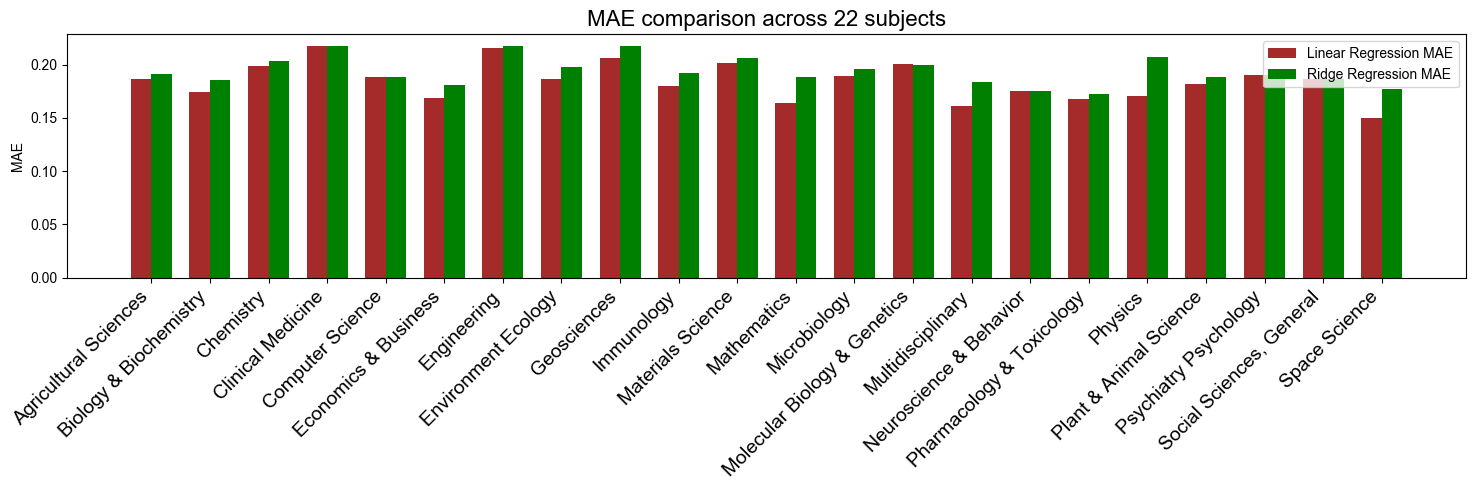

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制MAE对比
x = np.arange(len(academic_fields))
width = 0.35

plt.figure(figsize=(15, 5))
plt.bar(x - width/2, val_mae_lr.flatten(), width, label="Linear Regression MAE", color='brown')
plt.bar(x + width/2, val_mae_ridge.flatten(), width, label="Ridge Regression MAE", color='green')
plt.xticks(x, academic_fields, rotation=45, ha='right', fontsize=14)
plt.ylabel("MAE")
plt.title("MAE comparison across 22 subjects", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


# 测试

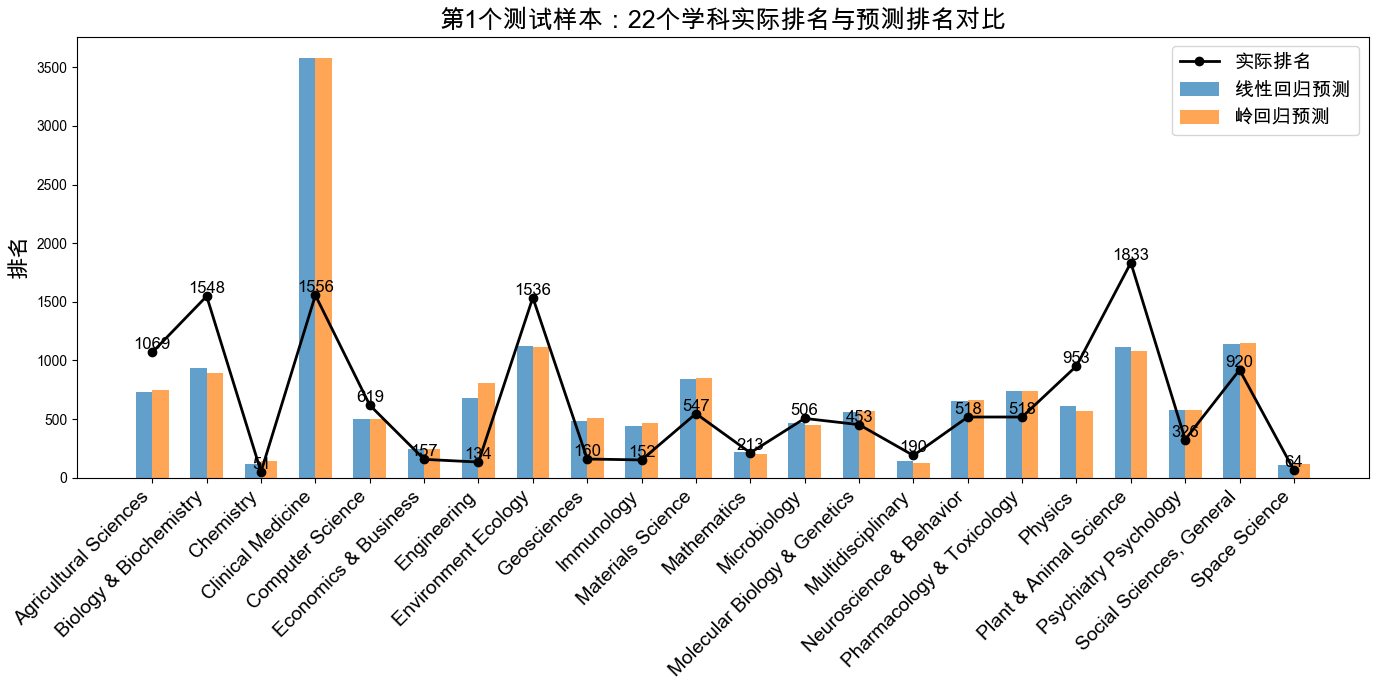

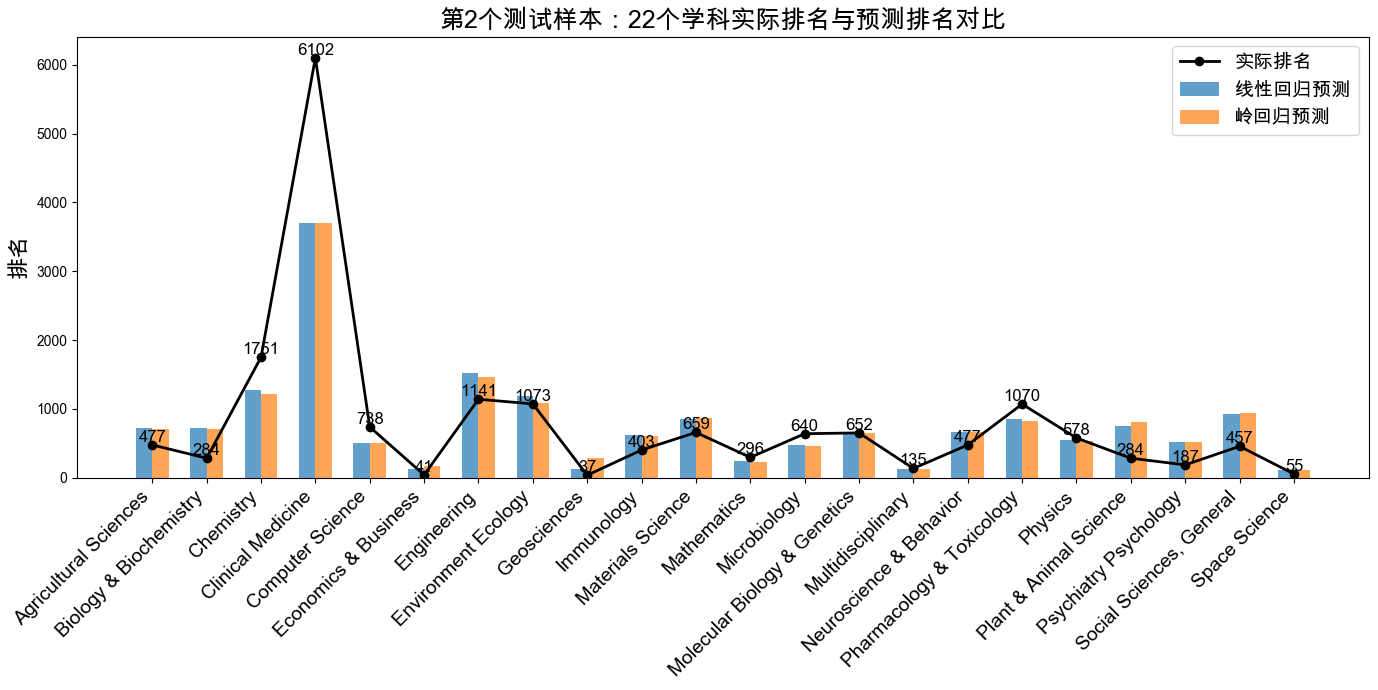

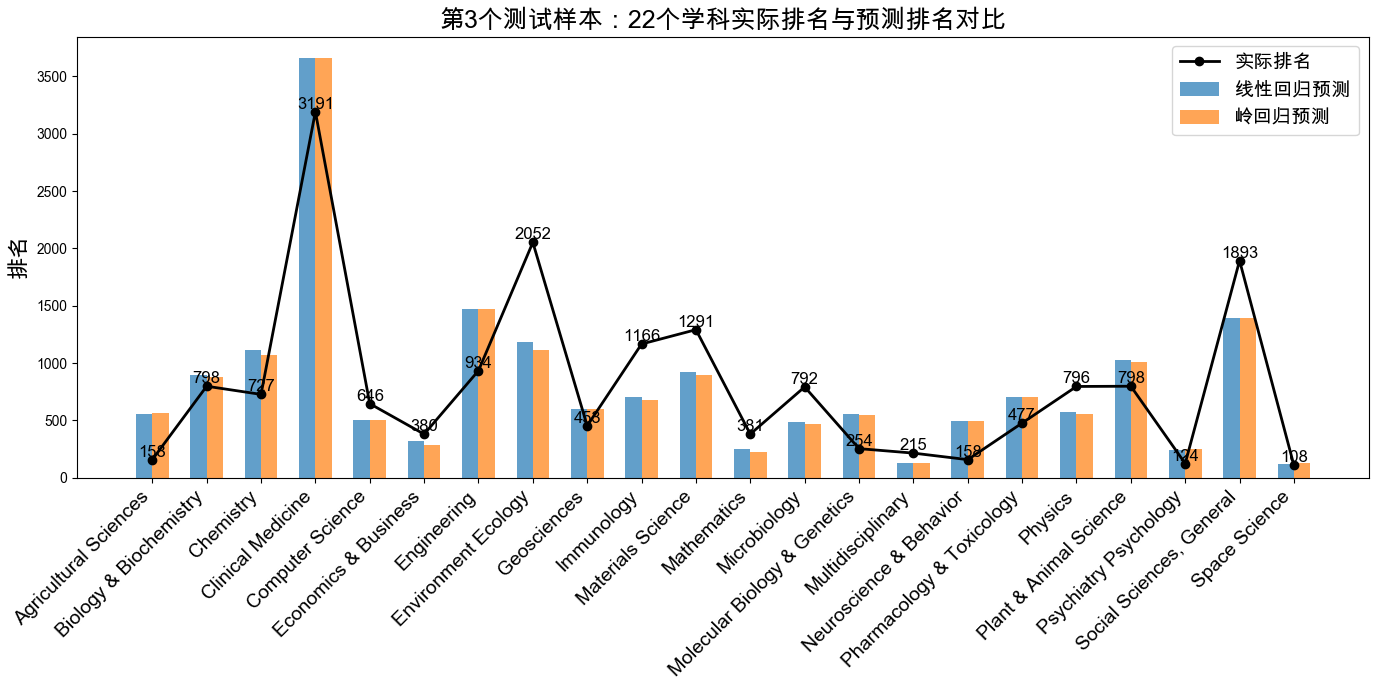

In [101]:
# 预测前三个测试样本22个学科的两种模型预测值和真实值，画三张图，分别表示三个测试样本的22个学科三个指标的对比

import matplotlib.pyplot as plt
import numpy as np

num_subjects = len(academic_fields)
num_samples_to_show = 3  # 前三个测试样本

# 用三个列表分别存储每个样本下，每个学科的实际排名和两组预测排名
real_ranks_samples = [[] for _ in range(num_samples_to_show)]
pred_lr_ranks_samples = [[] for _ in range(num_samples_to_show)]
pred_ridge_ranks_samples = [[] for _ in range(num_samples_to_show)]

for i, sd in enumerate(split_data):
    test_data = sd['test']
    X_test = test_data[:, 1:].astype(float)
    y_test = test_data[:, 0].astype(float)

    # 获取反归一化参数
    arr = all_data[i]
    arr_numeric_rows = []
    for row in arr:
        if isinstance(row[0], (int, float)) and not pd.isnull(row[0]):
            arr_numeric_rows.append(row)

    if len(arr_numeric_rows) > 0:
        df_temp = pd.read_csv(csv_files[i], skiprows=1, encoding='latin1')
        rank_col_original = df_temp[df_temp.columns[0]].apply(lambda x: int(x) if str(x).isdigit() else x)
        rank_col_original = rank_col_original[rank_col_original.apply(lambda x: isinstance(x, int))].values
        min_rank = np.min(rank_col_original)
        max_rank = np.max(rank_col_original)
    else:
        min_rank = 1
        max_rank = 1

    # 计算预测
    y_pred_lr_norm = np.dot(X_test, params[i, :3]) + params[i, 3]
    y_pred_ridge_norm = np.dot(X_test, ridge_params[i, :3]) + ridge_params[i, 3]

    # 反归一化
    if max_rank != min_rank:
        y_pred_lr_original = max_rank - y_pred_lr_norm * (max_rank - min_rank)
        y_pred_ridge_original = max_rank - y_pred_ridge_norm * (max_rank - min_rank)
        y_test_original = max_rank - y_test * (max_rank - min_rank)
    else:
        y_pred_lr_original = y_pred_lr_norm
        y_pred_ridge_original = y_pred_ridge_norm
        y_test_original = y_test

    # 负值设为0
    y_pred_lr_original = np.where(np.array(y_pred_lr_original) < 0, 0, y_pred_lr_original)
    y_pred_ridge_original = np.where(np.array(y_pred_ridge_original) < 0, 0, y_pred_ridge_original)
    y_test_original = np.where(np.array(y_test_original) < 0, 0, y_test_original)

    # 分别取前3个测试样本的实际和预测值
    for sample_idx in range(num_samples_to_show):
        if sample_idx < len(y_test_original):
            real_ranks_samples[sample_idx].append(float(y_test_original[sample_idx]))
            pred_lr_ranks_samples[sample_idx].append(float(y_pred_lr_original[sample_idx]))
            pred_ridge_ranks_samples[sample_idx].append(float(y_pred_ridge_original[sample_idx]))
        else:
            # 如果该学科的测试样本不足3个，用nan补齐
            real_ranks_samples[sample_idx].append(np.nan)
            pred_lr_ranks_samples[sample_idx].append(np.nan)
            pred_ridge_ranks_samples[sample_idx].append(np.nan)

# 绘图
width = 0.3
x = np.arange(num_subjects)

for sample_idx in range(num_samples_to_show):
    plt.figure(figsize=(max(14, num_subjects // 1.5), 7))
    
    plt.plot(x, real_ranks_samples[sample_idx], marker='o', color='black', linewidth=2, label='实际排名')
    plt.bar(x - width/2, pred_lr_ranks_samples[sample_idx], width, label='线性回归预测', alpha=0.7)
    plt.bar(x + width/2, pred_ridge_ranks_samples[sample_idx], width, label='岭回归预测', alpha=0.7)
    
    plt.xticks(x, academic_fields, rotation=45, ha='right', fontsize=14)
    plt.ylabel("排名", fontsize=16)
    plt.title(f"第{sample_idx+1}个测试样本：22个学科实际排名与预测排名对比", fontsize=18)
    plt.legend(fontsize=14)
    # 标注排名数值
    for xi, yi in zip(x, real_ranks_samples[sample_idx]):
        if not (np.isnan(yi) or yi is None):
            plt.text(xi, yi, f"{int(np.round(yi))}", color='black', fontsize=12, ha='center', va='bottom')
    plt.tight_layout()
    plt.show()
